<a href="https://colab.research.google.com/github/VadimFarutin/natural-language-processing/blob/master/task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install wandb -q
!pip install razdel

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import wandb

In [0]:
!wandb login

In [0]:
import re
import csv
import string
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence

# from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.corpus import stopwords
import string
from razdel import sentenize
from nltk.tokenize import wordpunct_tokenize as tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine

In [0]:
nltk.download('punkt')
nltk.download('stopwords')

In [0]:
SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
def pos_answer(paragraph, answer):
    sents = [token.text for token in list(sentenize(paragraph))]

    for sent in sents:
        ans_start = sent.lower().find(answer.lower())

        if ans_start != -1:
            return sent, ans_start

    return "", -1

In [0]:
def read_dataset():
    input_filename = "/content/drive/My Drive/train_qa.csv"
    dataset = []
    missed = []

    with open(input_filename, encoding='utf-8') as input_file:
        reader = csv.reader(input_file)
        next(reader)
        for row in reader:
            query = row[3]
            if query[-1] == '?':
                query = query[:-1]
            answer = row[4]
            if answer[-3:] == "...":
                answer = answer[:-3]
            if answer[:3] == "...":
                answer = answer[3:]
            if answer[0] == ' ':
                answer = answer[1:]
            if answer[0] in string.punctuation:
                answer = answer[1:]
            if answer[-1] in string.punctuation:
                answer = answer[:-1]

            sent, ans_start = pos_answer(row[2], answer)
            ans_len = len(answer)

            if ans_start != -1:
                dataset.append({'paragraph': re.split('(\W)', sent),
                                'query': re.split('(\W)', query),
                                'answer': (ans_start, ans_len)})
            else:
                missed.append(answer)
                                
    return dataset, missed


In [0]:
dataset, missed = read_dataset()

In [80]:
print(len(dataset))

50297


In [16]:
print(dataset[0])

{'paragraph': ['Первые', ' ', 'упоминания', ' ', 'о', ' ', 'строении', ' ', 'человеческого', ' ', 'тела', ' ', 'встречаются', ' ', 'в', ' ', 'Древнем', ' ', 'Египте', '.', ''], 'query': ['Где', ' ', 'встречаются', ' ', 'первые', ' ', 'упоминания', ' ', 'о', ' ', 'строении', ' ', 'человеческого', ' ', 'тела'], 'answer': (60, 16)}


In [20]:
print(missed[:10])

['собравшихся вместе героев нестеровского полотна На Руси. Душа народа ', 'Дж. Самнером', 'прелестное место , предлагающее Plen. and optabil. Coit. ', 'работы по мелодике стиха Эд. Сиверса', 'Впечатление. Восходящее солнце ', ' Концентрация многих шаперонов в клетке возрастает', 'Г. Р. Джонсон (Gary R. Johnson) и В. С. Фалгер (V.S. Falger', 'Traité élémentaire de chimie (I, chap. 3', 'общественные деятели, врачи и учителя, инженеры-конструкторы и преподаватели, труженики тыла и артисты, учёные и художники, строители, писатели, спортсмены и космонавты. Н', 'под руководством Дж. Р. Уомерзли и при участии Алана Тьюринга компьютере, известном как Марк I']


In [0]:
stemmer = SnowballStemmer("russian")
# stemmer = Mystem()

In [0]:
word_to_idx = defaultdict(lambda: 0)
separator = 60000
pad_value = 60001

In [0]:
max_p_len = [0]

In [0]:
def my_collate1(row, update_vocab):
    idx = []

    for word in row['paragraph']:
        stemmed = stemmer.stem(word.lower())

        if update_vocab and word_to_idx[stemmed] == 0:
            word_to_idx[stemmed] = len(word_to_idx) + 1
            
        idx.append(word_to_idx[stemmed])
    
    # max_p_len[0] = max(max_p_len[0], len(idx))
    idx.append(separator)

    for word in row['query']:
        stemmed = stemmer.stem(word.lower())

        if update_vocab and word_to_idx[stemmed] == 0:
            word_to_idx[stemmed] = len(word_to_idx) + 1
        
        idx.append(word_to_idx[stemmed])

    return torch.tensor(idx)

In [0]:
def my_collate2(row):
    pos = []
    idx = 0

    for word in row['paragraph']:
        cur_l = len(word)
        pos.append((idx, cur_l))
        idx += cur_l

    return pos

In [0]:
def pad_dataset(dataset, update_vocab):
    num_dataset = [my_collate1(item, update_vocab) for item in tqdm(dataset)]
    return pad_sequence(num_dataset, batch_first=True, padding_value=pad_value)

In [0]:
def pos_dataset(dataset):
    return [my_collate2(item) for item in tqdm(dataset)]

In [88]:
# dataset_padded = pad_dataset(dataset[:5000], True)
dataset_padded = pad_dataset(dataset, True)

In [89]:
print(len(word_to_idx))

52199


In [90]:
# dataset_pos = pos_dataset(dataset[:5000])
dataset_pos = pos_dataset(dataset)

In [0]:
def join_dataset(dataset_padded, dataset_pos, dataset):
    dataset_joined = []

    for sent, pos, row in tqdm(zip(dataset_padded, dataset_pos, dataset)):
        ans_start, ans_len = row['answer']
        y = np.array([0, 0])

        for pos_i in range(len(pos)):
            if pos[pos_i][0] == ans_start:
                y[0] = pos_i
            if pos[pos_i][0] == ans_start + ans_len:
                y[1] = pos_i - 1
            
        dataset_joined.append(np.append(sent.numpy(), y))

    return dataset_joined

In [92]:
dataset_joined = join_dataset(dataset_padded, dataset_pos, dataset)
# print(dataset_joined.shape)

In [0]:
train, val = train_test_split(dataset_joined, test_size=0.2, random_state=42)

In [94]:
print(train[0])

[   10     3  1991 ... 60001    24    30]


In [0]:
class MyLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, bidirectional, vocab_size, tagset_size):
        super(MyLSTM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                            num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        # self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, tagset_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.word_embeddings(x)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.transpose(x, 1, 2)
        x = F.log_softmax(x, dim=2)
        
        return x

In [0]:
def fit(model, train, val, optimizer, loss_function, epoch_cnt, batch_size):
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size)
    train_loss_values = []
    val_loss_values = []
    mse = nn.MSELoss()
            
    for epoch in tnrange(epoch_cnt, desc='Epoch'):
        for batch_data in train_loader:
            x, y = batch_data[:, :-2].to(device), batch_data[:, -2:].to(device)
            optimizer.zero_grad()
            output = model(x.long())
            y1, y2 = y[:, 0].reshape(-1), y[:, 1].reshape(-1)
            loss1 = loss_function(output[:, 0], y1.long())
            loss2 = loss_function(output[:, 1], y2.long())

            # _, ansx = output.max(dim=2)
            # loss3 = mse((ansx[:, 1] - ansx[:, 0]).float(), (y2 - y1).float())

            # loss = loss1 * 0.4995 + loss2 * 0.4995 + loss3 * 0.001
            loss = loss1 * 0.5 + loss2 * 0.5
            loss.backward()

            train_loss_values.append(loss.item())
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            wandb.log({
                "Train Loss": loss.item()})

        with torch.no_grad():
            loss_values = []
            for batch_data in val_loader:
                x, y = batch_data[:, :-2].to(device), batch_data[:, -2:].to(device)
                output = model(x.long())
                y1, y2 = y[:, 0].reshape(-1), y[:, 1].reshape(-1)
                loss1 = loss_function(output[:, 0], y1.long()).item()
                loss2 = loss_function(output[:, 1], y2.long()).item()

                # _, ansx = output.max(dim=2)
                # loss3 = mse((ansx[:, 1] - ansx[:, 0]).float(), (y2 - y1).float()).item()

                # loss = loss1 * 0.4995 + loss2 * 0.4995 + loss3 * 0.001
                loss = loss1 * 0.5 + loss2 * 0.5

                loss_values.append(loss)
            val_loss_values.append(np.mean(np.array(loss_values)))

            wandb.log({
                "Validation Loss": val_loss_values[-1]})

    return train_loss_values, val_loss_values 


In [0]:
embedding_dim = 64
hidden_dim = 64
num_layers = 4
bidirectional = True
vocab_size = max(pad_value, len(word_to_idx)) + 1
tagset_size = 2
epoch_cnt = 5
batch_size = 128

In [0]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# wandb.init(entity="vadim-farutin", project="HSE-NLP-task3")
# wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
model = MyLSTM(embedding_dim, hidden_dim, num_layers, bidirectional, vocab_size, tagset_size)
model = model.float()
model = model.to(device)

In [0]:
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [124]:
wandb.init(entity="vadim-farutin", project="HSE-NLP-task4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
# wandb.watch(model, log="all")

train_loss_values, val_loss_values =\
    fit(model, train, val, optimizer, loss_function, epoch_cnt, batch_size)

In [126]:
train_loss_values, val_loss_values =\
    fit(model, train, val, optimizer, loss_function, 3, batch_size)

In [0]:
def plot_loss_values(train_loss_values, val_loss_values):
    plt.plot(np.arange(len(train_loss_values)), train_loss_values, color='blue', label='train')
    plt.plot(np.arange(0, len(train_loss_values), len(train_loss_values) / epoch_cnt), val_loss_values, color='red', label='validation')
    plt.legend()
    plt.title("Loss values")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

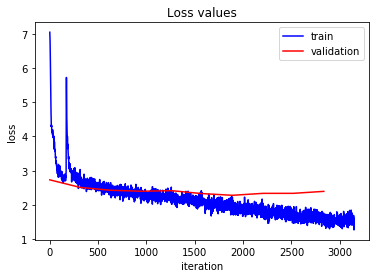

In [108]:
plot_loss_values(train_loss_values, val_loss_values)

In [0]:
stop_words = set(stopwords.words('russian'))

In [0]:
def find_closest(paragraph, query):
    sents = [token.text for token in list(sentenize(paragraph))] + [query]

    stemmed = []

    for sent in sents:
        sent_stemmed = []

        for word in tokenize(sent.translate(str.maketrans('', '', string.punctuation))):
            if word.lower() not in stop_words:
                sent_stemmed.append(stemmer.stem(word.lower()))

        sent_stemmed = ' '.join(sent_stemmed)
        stemmed.append(sent_stemmed)

    tf_idf = TfidfVectorizer().fit_transform(stemmed)

    min_cos = 1
    min_idx = None

    for i in range(len(sents) - 1):
        if min_cos >= cosine(tf_idf[i].todense(), tf_idf[-1].todense()):
            min_cos = cosine(tf_idf[i].todense(), tf_idf[-1].todense())
            min_idx = i
    
    return sents[min_idx]

In [0]:
def read_input():
    input_filename = "./dataset_281937_1.txt"
    X = []

    with open(input_filename, encoding='utf-8') as input_file:
        reader = csv.reader(input_file, delimiter='\t')
        next(reader)
        i = 2
        for row in reader:
            if (len(row) < 4):
                print(i)
            i += 1
            query = row[3]
            if query[-1] == '?':
                query = query[:-1]

            sent = find_closest(row[2], query)

            X.append({'paragraph': re.split('(\W)', sent),
                      'query': re.split('(\W)', query),
                      'query_id': row[1]})

    return X


In [145]:
test = read_input()
test_padded = pad_dataset(test, False)
test_pos = pos_dataset(test)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [146]:
print(test_padded.shape)

torch.Size([1000, 381])


In [0]:
with torch.no_grad():
    test_loader = torch.utils.data.DataLoader(test_padded, batch_size=batch_size)
    ans = None
    
    for batch_data in test_loader:
        x = batch_data.to(device)
        output = model(x.long())
        _, ansx = output.max(dim=2)
        ansx = ansx.cpu().numpy()
        if ans is None:
            ans = ansx
        else:
            ans = np.append(ans, ansx, axis=0)

In [148]:
print(ans[0])

[0 0]


In [0]:
output_filename = "./output.txt"

with open(output_filename, "w", encoding="utf-8") as output_file:
    for tags, row in zip(ans, test):
        start, end = tags
        if start >= len(row['paragraph']):
            start = end
        if start > end:
            end = len(row['paragraph']) - 1
        if end >= len(row['paragraph']):
            end = len(row['paragraph']) - 1
        output_file.write("%s\t%s\n" % (row['query_id'], "".join(row['paragraph'][start:end + 1])))
